In [1]:
import cv2, glob, shutil
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
paths = glob.glob('./train_data/images/*')
paths.sort()

lables = glob.glob('./train_data/labels/*')
lables.sort()

In [3]:
len(paths)

925

In [4]:
paths[0]

'./train_data/images/000001.jpg'

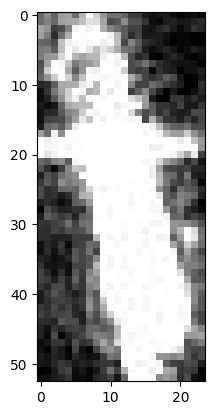

In [5]:
img = cv2.imread(paths[0])
plt.imshow(img[136:189, 169:193])

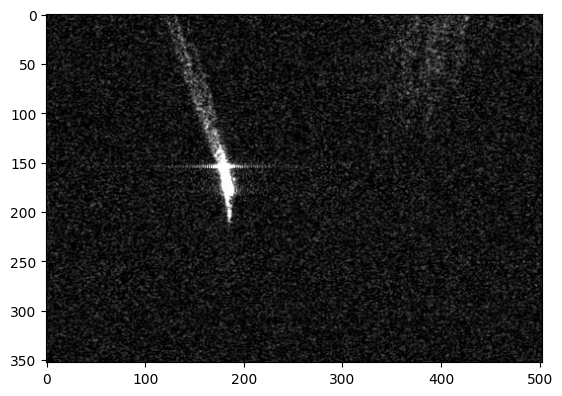

In [6]:
img = cv2.imread(paths[0])
plt.imshow(img)

In [7]:
open(lables[0]).readlines()

['ship 169 136 193 189\n']

In [8]:
!\rm -rf yolo-dataset runs
!mkdir yolo-dataset

!mkdir yolo-dataset/images
!mkdir yolo-dataset/images/train
!mkdir yolo-dataset/images/val

!mkdir yolo-dataset/labels
!mkdir yolo-dataset/labels/train
!mkdir yolo-dataset/labels/val

In [9]:
def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[2])/2.0 - 1
    y = (box[1] + box[3])/2.0 - 1
    w = box[2] - box[0]
    h = box[3] - box[1]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

for path, label in zip(paths[:-100], lables[:-100]):
    size = cv2.imread(path).shape
    size = [size[1], size[0]]
    with open('./yolo-dataset/labels/train/' + path.split('/')[-1][:-3] + 'txt', 'w') as up:
        lines = open(label).readlines()
        for line in lines:
            line = line.strip()
            line = line.split()
            
            box = [int(line[1]), int(line[2]), int(line[3]), int(line[4])]
            box = convert(size, box)
            up.write('0 ' + " ".join([str(a) for a in box]) + '\n')
    
    shutil.copy(path, './yolo-dataset/images/train/')
    
for path, label in zip(paths[-100:], lables[-100:]):
    size = cv2.imread(path).shape
    size = [size[1], size[0]]
    with open('./yolo-dataset/labels/val/' + path.split('/')[-1][:-3] + 'txt', 'w') as up:
        lines = open(label).readlines()
        for line in lines:
            line = line.strip()
            line = line.split()
            
            box = [int(line[1]), int(line[2]), int(line[3]), int(line[4])]
            box = convert(size, box)
            up.write('0 ' + " ".join([str(a) for a in box]) + '\n')
    
    shutil.copy(path, './yolo-dataset/images/val/')

In [10]:
from ultralytics import YOLO

model = YOLO("./yolov8m.pt")
results = model.train(data="./yolo-dataset.yaml", epochs=20, batch=8)  # 训练模型

Ultralytics YOLOv8.0.157 🚀 Python-3.8.16 torch-2.0.0a0+git70f6d0c CUDA:0 (AMD Radeon RX 6600 XT, 8176MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=./yolov8m.pt, data=./yolo-dataset.yaml, epochs=20, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fal

In [14]:
from ultralytics import YOLO
import glob
model = YOLO("runs/detect/train/weights/best.pt")

predictions = model.predict('./train_data/images/000007.jpg', imgsz=640)


image 1/1 /var/lib/jenkins/work/boat/train_data/images/000007.jpg: 480x640 1 ship, 1147.9ms
Speed: 1.4ms preprocess, 1147.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


In [15]:
for prediction in predictions[0].boxes.data:
    break

In [16]:
predictions[0].boxes.data

tensor([[204.6050, 269.0226, 219.7724, 310.3411,   0.7062,   0.0000]], device='cuda:0')

In [18]:
open('./train_data/labels/000007.txt').readlines()

['ship 204 265 221 312\n']

In [19]:
!tar -cvzf tilting-ship.tar.gz tilting-ship

tar: tilting-ship: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [41]:
!s3cmd put tilting-ship.tar.gz s3://ai-competition/0fs76epw/tilting-ship.tar.gz

upload: 'tilting-ship.tar.gz' -> 's3://ai-competition/0fs76epw/tilting-ship.tar.gz'  [part 1 of 4, 15MB] [1 of 1]
 15728640 of 15728640   100% in   19s   789.31 kB/s  done
upload: 'tilting-ship.tar.gz' -> 's3://ai-competition/0fs76epw/tilting-ship.tar.gz'  [part 2 of 4, 15MB] [1 of 1]
 15728640 of 15728640   100% in   19s   772.08 kB/s  done
upload: 'tilting-ship.tar.gz' -> 's3://ai-competition/0fs76epw/tilting-ship.tar.gz'  [part 3 of 4, 15MB] [1 of 1]
 15728640 of 15728640   100% in   20s   752.27 kB/s  done
upload: 'tilting-ship.tar.gz' -> 's3://ai-competition/0fs76epw/tilting-ship.tar.gz'  [part 4 of 4, 811kB] [1 of 1]
 831323 of 831323   100% in    0s   906.84 kB/s  done


- run.py内容

```python
from ultralytics import YOLO
import glob
model = YOLO("./best.pt")

for path in glob.glob('/work/data/object-detection-for-tilting-ships-test-set/*'):
    predictions = model.predict(path, imgsz=640)
    with open("/work/output/" + path.split('/')[-1][:-4] + '.txt', 'w') as file:
        for idx, prediction in enumerate(predictions[0].boxes.data):
            cls = int(predictions[0].boxes.cls[idx].item())
            cls = 'ship'
            score = predictions[0].boxes.conf[idx].item()
            file.write(f"{cls} {score} {int(prediction[0].item())} {int(prediction[1].item())} {int(prediction[2].item())} {int(prediction[3].item())}\n")   
```